# Evaluate commuter data over time
The code below takes labbeled data, trains a NN using a growing amount of training data.
Since this is done itaratively and compared to predictions towards a test set an estimation can be made over how fast the model converges.


In [1]:
#Setup
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai
from fastai.vision import *
PATH="../data/"
dep_var = 'journey'
cat_names = ["detectedActivity","weekday"]
cont_names =["geoHash","minuteOfDay"]
procs = [FillMissing, Categorify, Normalize]
# Uncomment active user
user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn

def predict_journeys(learner,dataset):
    "This can be thing that is already  in the framework... Confusion matrix adding test set..., but I have some hard time finding the data in the learner"
    "If filename exists all wrong predictions will be saved."
    result = 0
    accuracy = 0
    #details = []
    for x in range(0,dataset.shape[0]):
        correct = dataset.iloc[x].journey  #remove journey
        predicted = learner.predict(dataset.iloc[x]);
        #print(str(correct)+":"+str(predicted[0]))
        if (str(correct)==str(predicted[0])):
            result=result+1
        #details.append([str(correct),str(predicted[0]),str(round(predicted[2].max().item()))])
    accuracy=result/dataset.shape[0]
    return(accuracy)
    
def predict_journey(learner,detectedActivity,geoHash,minuteOfday,weekday):
    data = np.array([['','detectedActivity','geoHash','minuteOfDay','weekday'],
                ["row1",detectedActivity,geoHash,minuteOfday,weekday]])            
    dr=pd.DataFrame(data=data[1:,1:],
                    index=data[1:,0],
                    columns=data[0,1:]).astype(np.int64)
    predicted = learner.predict(dr.iloc[0])
    return(predicted[0],str(round(predicted[2].max().item(),2)))

# def evaluate_learner(rows_per_training:int,trainingset,testset,length_teachingSet=0): #Minimal start for any training can bne used for offset
#     "Asumes a constant amount of rows per day in training"
#     result = []
#     if length_teachingSet>0: #do teaching and add thus add startdata for day 0
#         start_point = length_teachingSet
#     else: #no teachin set exists add row for day 0
#         result.append([0,0,0])
#         start_point = rows_per_training
#     for rows in range(start_point,len(trainingset),rows_per_training):
#         df=trainingset[0:rows]
#         df=make_shure_we_got_enough_rows(df)
#         #valid_idx= list(np.random.randint(0,len(df),int(len(df)*0.1))) #If we want 10% random instead of same 10 rows...
#         valid_idx = list(range(int(len(df)*0.9), len(df)))  #Here always last 10% is used for validation
#         data = (TabularList.from_df(df, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
#                 .split_by_idx(valid_idx)
#                 .label_from_df(cols=dep_var)
#                 .databunch())
#         learner=tabular_learner(data, layers=[200,100], metrics=accuracy)
#         learner.fit_one_cycle(30)
#         #learner.fit(5, 1e-2)
#         sizeR = len(learner.recorder.metrics)
#         resultTest = predict_journeys(learner,testset)
#         result.append([rows,learner.recorder.metrics[sizeR-1][0].item(),resultTest])
#     return (result)

def evaluate_learner_varying_batch_size(trainingset,testset,teachingset=None):
    "Trains in batches. A new batch starts with -- and ends with next row that starts with --"
    "Training is done from the first row that starts with -- until next row that starts with -- and thus training is done with a growing amount of rows"
    "Rows in a batch are duplicated so there are aways at least 500 rows for training (no new information added and no other data agumentation)"
    "If an initial teaching set is used add the rows first without an initial row starting with --."
    result = []
    iterativeTrainingSet = DataFrame(testset[0:0]) #copy structure
    for row in trainingset.itertuples():
        if row[1].startswith('--'): #New batch
            if len(iterativeTrainingSet)>0 or teachingset is not None:
                df=iterativeTrainingSet.copy() #crete another! copy to train from
                df = df.astype({'detectedActivity':'int','geoHash':'int', 'minuteOfDay':'int','weekday':'int',"journey":'int'})
                if teachingset is not None:
                    df = pd.concat([teachingset,df])
                df=make_shure_we_got_enough_rows(df)  ##Add rows so it is big enough to train from
                valid_idx= list(np.random.randint(0,len(df),int(len(df)*0.1))) #If we want 10% random instead of same 10 rows...
                #valid_idx = list(range(int(len(df)*0.9), len(df)))  #Here always last 10% is used for validation
                data = (TabularList.from_df(df, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                    .split_by_idx(valid_idx)
                    .label_from_df(cols=dep_var)
                    .databunch())
                learner=tabular_learner(data, layers=[200,100], metrics=accuracy)
                learner.fit_one_cycle(20)
                sizeR = len(learner.recorder.metrics)
                resultTest = predict_journeys(learner,testset)
                result.append([len(iterativeTrainingSet),learner.recorder.metrics[sizeR-1][0].item(),resultTest])
            else: ##it is first row or no teaching data exists(Cold start) so no training is possible
                result.append([0,0,0])
        else: # just add the for to training set
            iterativeTrainingSet = iterativeTrainingSet.append(trainingset.iloc[row[0]])
    return (result)

def make_shure_we_got_enough_rows(dataset,minrows=1000):
    "If the dataset has fewer rows that minrows, whole dataset copies will be added at the end until at least minrows exists"
    newset = pd.DataFrame()
    while newset.shape[0]<minrows:
        newset = pd.concat([newset,dataset])
    return(newset)

def save_results(filename,result):
    a = np.asarray(result)
    np.savetxt("saved/"+filename,a,delimiter=',',fmt="%10.2f")

### Iterative training daily during the initial 14 days of use.
We train every day from the start; the data is created using the personas travel patterns over the first 14 days of use.

In [2]:
%%capture
trainingset = pd.read_csv(PATH+user+"_start14days.csv")
testset = pd.read_csv(PATH+user+"_test.csv")
resultMLTrain=evaluate_learner_varying_batch_size(trainingset,testset)
save_results("Iterative_time_"+user+".csv",resultMLTrain)

### Iterative training daily during the initial 14 days of use, a teaching set is added to the training data.
Here we add an idealised teaching set in the beginning of our dataset. Then we start training from day 0 using only the data in the teachingset and contiuing as in the section above.
Teachingset:

Andrea:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/ehaBtfOPDNZjzy1MEvjQmGo4Zv12_teaching_set.csv)
[Minimal](../commuter/data/ehaBtfOPDNZjzy1MEvjQmGo4Zv12_teaching_set_minimal.csv)

Björn:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2_teaching_set.csv)
[Minimal](../commuter/data/hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2_teaching_set_minimal.csv)

Maria:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/tnK534JMwwfhvUEycn69HPbhqkt2_teaching_set.csv)
[Minimal](../commuter/data/tnK534JMwwfhvUEycn69HPbhqkt2_teaching_set_minimal.csv)

In [3]:
%%capture
#teachingset = pd.read_csv(PATH+user+"_teaching_set.csv")
teachingset = pd.read_csv(PATH+user+"_teaching_set_minimal.csv")
trainingset = pd.read_csv(PATH+user+"_start14days.csv")
testset = pd.read_csv(PATH+user+"_test.csv")
resultMLTrain=evaluate_learner_varying_batch_size(trainingset,testset,teachingset)
#save_results("Iterative_time_teach"+user+".csv",resultMLTrain)
save_results("Iterative_time_teach_minimal"+user+".csv",resultMLTrain)

### Iterative training daily during the initial 14 days of use, we use a model traied on data from the same distribution as the test set.
As a comparison to the training above this model is trained using data created using the persona envisioning one year of use. The trained model is pretrained and deployed, the model is updated iteratively using incoming data. 

In [2]:
%%capture
teachingset = pd.read_csv(PATH+user+"_train_valid.csv")
trainingset = pd.read_csv(PATH+user+"_start14days.csv")
testset = pd.read_csv(PATH+user+"_test.csv")
resultMLTrain=evaluate_learner_varying_batch_size(trainingset,testset,teachingset)
save_results("Iterative_time_supervised"+user+".csv",resultMLTrain)

### Show results
Prints results from training done in the cells above.

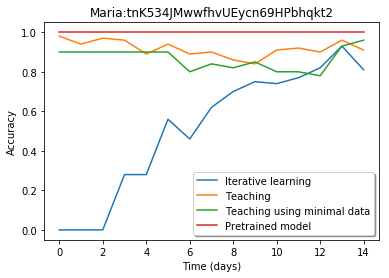

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import pandas as pd
personas = pd.read_csv("saved/personas.csv")
#Uncomment to look at individual result for other users that the default declared above.
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
personaname = personas.loc[personas['id']==user]
learning_ax0= pd.read_csv("saved/Iterative_time_"+user+".csv",header=None).values
teaching_ax0 = pd.read_csv("saved/Iterative_time_teach"+user+".csv",header=None).values
teaching_min_ax0 = pd.read_csv("saved/Iterative_time_teach_minimal"+user+".csv",header=None).values
supervised_min_ax0 = pd.read_csv("saved/Iterative_time_supervised"+user+".csv",header=None).values
fig, ax0 = plt.subplots()
ax0.set_title(personaname ['name'].iloc[0]+":"+user)
ax0.plot(learning_ax0[:,2],label='Iterative learning')
ax0.plot(teaching_ax0[:,2],label='Teaching')
ax0.plot(teaching_min_ax0[:,2],label='Teaching using minimal data')
ax0.plot(supervised_min_ax0[:,2],label='Pretrained model')
plt.xlabel('Time (days)')
plt.ylabel('Accuracy')
legend = ax0.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

## Misc
Used explorative code can be removed later. Ignore or read adds nothing really except expainability on my level of thinking.
## Remove

In [2]:
%%capture
#Training without teaching set on shuffeled training data
trainingset = pd.read_csv(PATH+user+"_train_valid.csv")
#Take 14 days
trainingset=trainingset[0:int(trainingset.shape[0]/24)]
testset = pd.read_csv(PATH+user+"_test.csv")
size=trainingset.shape[0]
rows_per_training = int(size/14) # will result in about one training per day
print(rows_per_training)
print(len(trainingset))
resultTrain = evaluate_learner(rows_per_training,trainingset,testset)
save_results("Iterative_"+user+".csv",resultTrain)

In [2]:
%%capture
#Training with teaching set on shuffeled training data
trainingset = pd.read_csv("data/"+user+"_train_valid.csv")
#Take first two weeks
trainingset=trainingset[0:int(trainingset.shape[0]/24)]
size=trainingset.shape[0]
rows_per_training = int(size/14) # will result in about one training per day
teachingset = pd.read_csv(PATH+user+"_teaching_set.csv")
trainingset = pd.concat([teachingset,trainingset])
testset = pd.read_csv(PATH+user+"_test.csv")
resultTeach = evaluate_learner(rows_per_training,trainingset,testset,len(teachingset))
save_results("TeachingIterative_"+user+".csv",resultTeach)

### Teaching
If an idealised teaching set is created that contains all combinations of categorical columns (activity and weekday) combined with a time placed in the middle of the timespan for the scenario and location at the departure station.

epoch,train_loss,valid_loss,accuracy
1,1.006904,1.358945,0.520000
2,0.639913,1.081976,0.520000
3,0.419776,0.595423,0.950000
4,0.285612,0.236548,1.000000
5,0.201564,0.088055,1.000000
6,0.146039,0.029964,1.000000
7,0.108362,0.015801,1.000000
8,0.082248,0.011279,1.000000
9,0.063418,0.010693,1.000000
10,0.049880,0.010589,1.000000


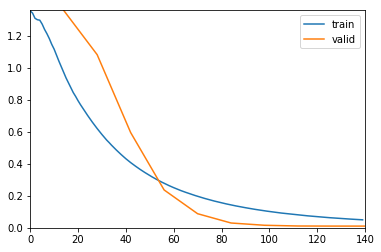

In [12]:
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filename = user+"_teaching_set_minimal.csv"
teachingSet = pd.read_csv(PATH+filename)
teachingSet=make_shure_we_got_enough_rows(teachingSet)
valid_idx= list(np.random.randint(0,len(teachingSet),int(len(teachingSet)*0.1))) #If we want 10% random instead of same 10 rows...
#valid_idx = list(range(int(len(teachingSet)*0.9), len(teachingSet)))  #Here always last 10% is used for validation
data = (TabularList.from_df(teachingSet, path=user, cat_names=cat_names, cont_names=cont_names, procs=procs)
    .split_by_idx(valid_idx)
    .label_from_df(cols=dep_var)
    .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
learner.fit_one_cycle(10)

### Training


Run test one cycle with part of the training set.

epoch,train_loss,valid_loss,accuracy
1,1.959080,1.757333,0.936667
2,0.976438,0.216201,0.980000
3,0.446469,0.081628,0.986667
4,0.226011,0.054558,0.986667
5,0.129927,0.039644,0.990000
6,0.087971,0.037354,0.990000
7,0.063135,0.032193,0.990000
8,0.052338,0.031125,0.990000
9,0.044309,0.030359,0.990000
10,0.041411,0.029329,0.990000


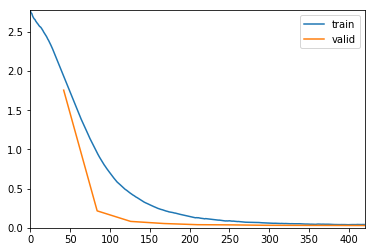

In [2]:
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filename = user+"_train_valid.csv"
dataSetIn = pd.read_csv(PATH+filename)
dataSet=dataSetIn[0:3000]
dataSet=make_shure_we_got_enough_rows(dataSet)
#valid_idx = list(np.random.randint(0,len(dataSet),int(len(dataSet)*0.1)))
valid_idx = list(range(int(len(dataSet)*0.9), len(dataSet)))  #Here always last 10% is used for validation 
data = (TabularList.from_df(dataSet, path=user, cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
#%time learner.fit_one_cycle(10)
learner.fit_one_cycle(10)

### Evaluate on test set
Evaluate using the test set on a trained "learner"*

In [13]:
#%%capture
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filenameTest = user+"_test.csv"
datasetTest = pd.read_csv(PATH+filenameTest)
accuracyTest,details = predict_journeys(learner,datasetTest)
print(accuracyTest)

In [14]:
print(accuracyTest)

0.8941798941798942


In [25]:
# Errors
dd=np.array(details)
for x in range (0,len(details)):
    if dd.item((x,0))!=dd.item((x,1)):
        print(dd[x])

['8107980000' '8107981156' '1']
['8107980000' '8107981156' '1']
['8000081079' '8115681079' '1']
['8107980000' '8107981156' '1']
['8107980300' '8107981156' '1']
['8000081079' '8115681079' '1']
['8030081079' '8115681079' '1']
['8107980000' '8107981156' '1']
['8107980000' '8107981156' '1']
['8000081079' '8115681079' '1']
['8107980000' '8107981156' '1']
['8107980300' '8107981156' '1']
['8000081079' '8115681079' '1']
['8107980000' '8107981156' '1']
['8107980000' '8107981156' '1']
['8000081079' '8115681079' '1']
['8000081079' '8115681079' '1']
['8000081079' '8115681079' '1']
['8107980000' '8107981156' '1']
['8107980000' '8107981156' '1']
['8000081079' '8115681079' '1']
['8107980000' '8107981156' '1']
['8000081079' '8115681079' '1']


#### Predict on individual journey

In [29]:
#prediction,accuracy = predict_journey(learner,3,1243184839,603,6) #8107980000 "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" Andrea
#prediction,accuracy = predict_journey(learner,3,1242202139,806,6) #8033880159 "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
prediction,accuracy = predict_journey(learner,3,1242479279,527,5) #8121680000 "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
print("Predicted journey from: "+str(prediction)[0:5]+" to " +str(prediction)[5:10]+ " with accuracy "+str(accuracy));

Predicted journey from: 81156 to 80002 with accuracy 1.0


### Confusion Matrix and other stuff

In [8]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)

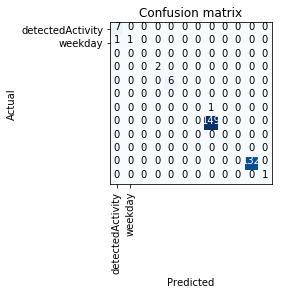

In [9]:
#Interesting but why is detectedactivity presented? It should be the journeys????
#Contue working on this since it gives information on wrong predictions. Real travels can be added so it can be read by a domai expert.
interp.plot_confusion_matrix()

### Test code for 14 days iterative training.

In [2]:
%%capture
##read 14 days try
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filenameTrain = user+"_start14days.csv"
datasetTrain = pd.read_csv(PATH+filenameTrain)
iterativeTrainingSet = DataFrame(datasetTrain[0:0])
testset = pd.read_csv(PATH+user+"_test.csv")
result = []
for row in datasetTrain.itertuples():
    if row[1].startswith('--'):
        print("Train until: "+row[1]) ##New batch
        if len(iterativeTrainingSet)>0:
            df = iterativeTrainingSet.copy()
            df = df.astype({'detectedActivity':'int','geoHash':'int', 'minuteOfDay':'int','weekday':'int',"journey":'int'})
            #print(df.head(20))
            df=make_shure_we_got_enough_rows(df)
            valid_idx = list(range(int(len(df)*0.9), len(df)))  #Here always last 10% is used for validation 
            data = (TabularList.from_df(df, path=user, cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch())
            learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
            learner.fit_one_cycle(20)
            resultTest = predict_journeys(learner,testset)
            print("Prediction: "+str(resultTest))
            sizeR = len(learner.recorder.metrics)
            result.append([len(iterativeTrainingSet),learner.recorder.metrics[sizeR-1][0].item(),resultTest])
        else:
            result.append([0,0,0])
    else:
        iterativeTrainingSet = iterativeTrainingSet.append(datasetTrain.iloc[row[0]])
print(result)        


In [3]:
print(result)

[[0, 0, 0], [6, 1.0, 0.05291005291005291], [14, 1.0, 0.023809523809523808], [20, 1.0, 0.9047619047619048], [27, 1.0, 0.9047619047619048], [33, 1.0, 0.9047619047619048], [43, 1.0, 0.9047619047619048], [52, 1.0, 0.9047619047619048], [52, 1.0, 0.9047619047619048], [59, 0.9801980257034302, 0.9047619047619048], [68, 0.9803921580314636, 0.9047619047619048], [77, 0.9801980257034302, 0.9021164021164021], [85, 0.9803921580314636, 0.9153439153439153], [93, 0.9805825352668762, 0.9047619047619048], [103, 0.9805825352668762, 0.9126984126984127]]


### Save Model

In [3]:
learner.save(name=user)
data.export()

In [9]:
### Load model and fnfer journey

In [3]:
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai
# Uncomment active user
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
def predict_journey(learner,detectedActivity,geoHash,minuteOfday,weekday):
    data = np.array([['','detectedActivity','geoHash','minuteOfDay','weekday'],
                ["row1",detectedActivity,geoHash,minuteOfday,weekday]])            
    dr=pd.DataFrame(data=data[1:,1:],
                    index=data[1:,0],
                    columns=data[0,1:]).astype(np.int64)
    predicted = learner.predict(dr.iloc[0])
    return(predicted[0],str(round(predicted[2].max().item(),2)))
data = TabularDataBunch.load_empty(user)
learn_andrea = tabular_learner(data, layers=[200,100])
learn_andrea.load(user);
prediction,accuracy = predict_journey(learn_andrea,3,1243184839,603,6) #8107980000 "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" Andrea
#prediction,accuracy = predict_journey(learner,3,1242202139,806,6) #8033880159 "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
#prediction,accuracy = predict_journey(learn_andrea,3,1242479279,527,5) #8121680000 "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
print("Predicted journey from: "+str(prediction)[0:5]+" to " +str(prediction)[5:10]+ " with accuracy "+str(accuracy));

Predicted journey from: 81079 to 80000 with accuracy 0.91
